# Dataset Preparation

## CASIA-FASD Dataset ([Kaggle](https://www.kaggle.com/datasets/minhnh2107/casiafasd))

In [1]:
!pip install kaggle --q

In [2]:
!kaggle datasets download -d minhnh2107/casiafasd
# https://www.kaggle.com/datasets/minhnh2107/casiafasd

Dataset URL: https://www.kaggle.com/datasets/minhnh2107/casiafasd
License(s): unknown
 84% 59.0M/70.6M [00:00<00:00, 94.2MB/s]
100% 70.6M/70.6M [00:00<00:00, 85.3MB/s]


In [3]:
!unzip casiafasd.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_img/test_img/depth/18_HR_4.avi_250_fake.jpg  
  inflating: test_img/test_img/depth/18_HR_4.avi_25_fake.jpg  
  inflating: test_img/test_img/depth/18_HR_4.avi_50_fake.jpg  
  inflating: test_img/test_img/depth/18_HR_4.avi_75_fake.jpg  
  inflating: test_img/test_img/depth/19_1.avi_25_real.jpg  
  inflating: test_img/test_img/depth/19_1.avi_50_real.jpg  
  inflating: test_img/test_img/depth/19_1.avi_75_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_100_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_125_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_150_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_175_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_200_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_25_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_50_real.jpg  
  inflating: test_img/test_img/depth/19_2.avi_75_real.jpg  
  inflating: test_img/test_img/

## Cropping the faces with MTCNN Model

In [4]:
!pip install mtcnn --q
!pip install pillow --q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.3 MB/s eta 0:00:00


In [5]:
from mtcnn import MTCNN
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [6]:
def load_image_paths(directory):
    image_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            image_paths.append(os.path.join(directory, filename))
    return image_paths

image_paths = load_image_paths('/content/train_img/train_img/color')

In [7]:
image_paths

['/content/train_img/train_img/color/13_3.avi_125_fake.jpg',
 '/content/train_img/train_img/color/19_HR_1.avi_150_real.jpg',
 '/content/train_img/train_img/color/11_1.avi_125_real.jpg',
 '/content/train_img/train_img/color/3_HR_2.avi_25_fake.jpg',
 '/content/train_img/train_img/color/1_HR_1.avi_75_real.jpg',
 '/content/train_img/train_img/color/12_HR_1.avi_100_real.jpg',
 '/content/train_img/train_img/color/7_3.avi_225_fake.jpg',
 '/content/train_img/train_img/color/3_7.avi_100_fake.jpg',
 '/content/train_img/train_img/color/9_HR_1.avi_150_real.jpg',
 '/content/train_img/train_img/color/4_2.avi_50_real.jpg',
 '/content/train_img/train_img/color/8_3.avi_125_fake.jpg',
 '/content/train_img/train_img/color/20_8.avi_75_fake.jpg',
 '/content/train_img/train_img/color/4_HR_4.avi_175_fake.jpg',
 '/content/train_img/train_img/color/5_4.avi_50_fake.jpg',
 '/content/train_img/train_img/color/2_3.avi_125_fake.jpg',
 '/content/train_img/train_img/color/20_4.avi_125_fake.jpg',
 '/content/train_img/

In [8]:
def detect_and_crop_faces(image_path, detector):
    image = Image.open(image_path)
    image_np = np.asarray(image)
    result = detector.detect_faces(image_np)
    if result:
        for person in result:
            bounding_box = person['box']
            keypoints = person['keypoints']

            # Crop the detected face
            x, y, width, height = bounding_box
            cropped_face = image_np[y:y+height, x:x+width]

            # Convert the cropped face back to an image
            cropped_face_image = Image.fromarray(cropped_face)

            return cropped_face_image
    return None

# Initialize the MTCNN face detector
detector = MTCNN()

# Process each image
cropped_faces = []
for image_path in image_paths[:10]:
    cropped_face = detect_and_crop_faces(image_path, detector)
    if cropped_face:
        cropped_faces.append(cropped_face)

1/1 [==============================] - 0s 19ms/step


In [9]:
cropped_faces

[<PIL.Image.Image image mode=RGB size=159x207>,
 <PIL.Image.Image image mode=RGB size=166x211>,
 <PIL.Image.Image image mode=RGB size=192x223>,
 <PIL.Image.Image image mode=RGB size=167x206>,
 <PIL.Image.Image image mode=RGB size=149x200>,
 <PIL.Image.Image image mode=RGB size=168x222>,
 <PIL.Image.Image image mode=RGB size=160x215>,
 <PIL.Image.Image image mode=RGB size=158x196>,
 <PIL.Image.Image image mode=RGB size=168x220>,
 <PIL.Image.Image image mode=RGB size=151x198>]

In [10]:
output_dir = '/content/cropped_faces/train_img/color'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for i, cropped_face in enumerate(cropped_faces):
    cropped_face.save(os.path.join(output_dir, f'cropped_face_{i}.jpg'))

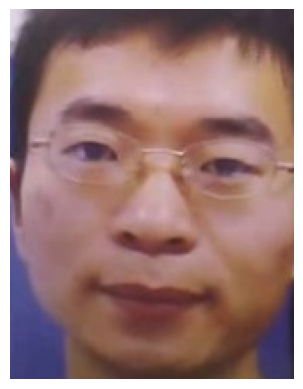

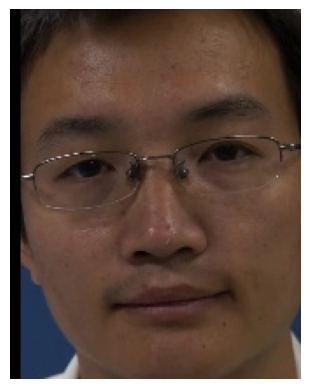

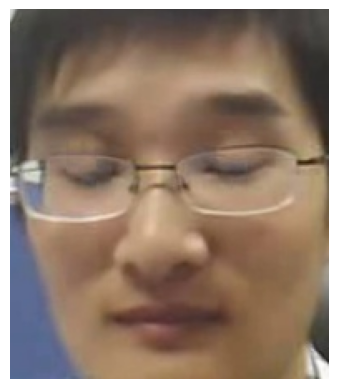

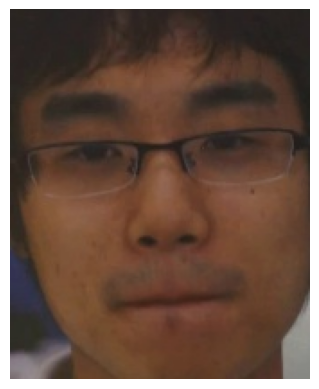

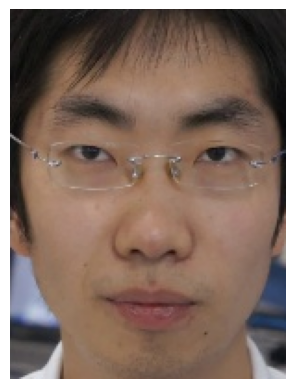

In [11]:
# Display a few cropped faces
for cropped_face in cropped_faces[:5]:
    plt.imshow(cropped_face)
    plt.axis('off')
    plt.show()

## Feature Extraction

In [12]:
import cv2
from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray
from numpy.fft import fft2, fftshift

In [13]:
def extract_fft_features(image):
    """
    Extract frequency domain features using FFT.
    """
    gray_image = rgb2gray(np.asarray(image))
    f = fft2(gray_image)
    fshift = fftshift(f)
    magnitude_spectrum = np.log(np.abs(fshift) + 1)
    return magnitude_spectrum

In [14]:
def extract_lbp_features(image, P=8, R=1):
    """
    Extract texture features using Local Binary Patterns (LBP).
    """
    gray_image = rgb2gray(np.asarray(image))
    lbp = local_binary_pattern(gray_image, P, R, method="uniform")
    return lbp

In [15]:
def display_image(image, title="Image"):
    """
    Display an image using matplotlib.
    """
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

In [16]:
# Process each cropped face image to extract features
fft_features = []
lbp_features = []

for cropped_face in cropped_faces:
    # Extract and store FFT features
    fft_feature = extract_fft_features(cropped_face)
    fft_features.append(fft_feature)

    # Extract and store LBP features
    lbp_feature = extract_lbp_features(cropped_face)
    lbp_features.append(lbp_feature)

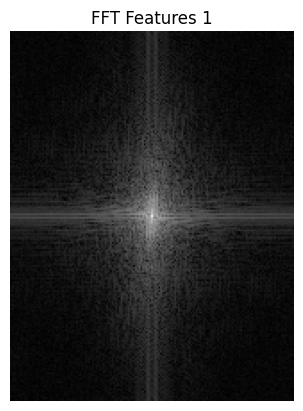

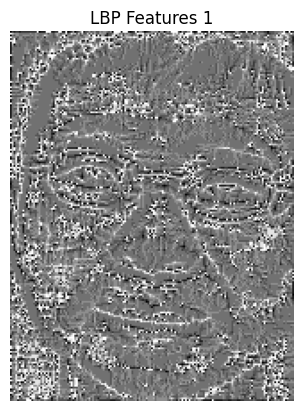

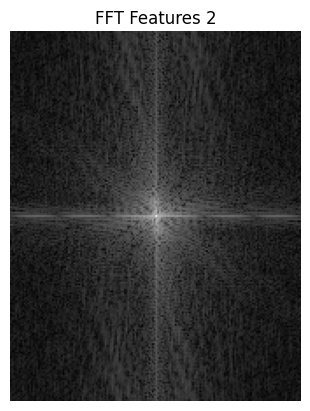

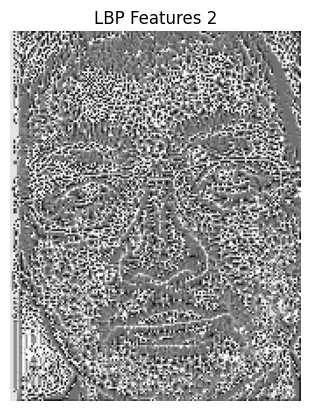

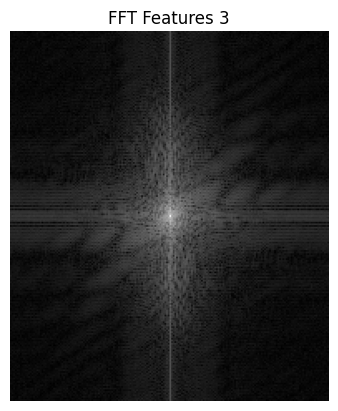

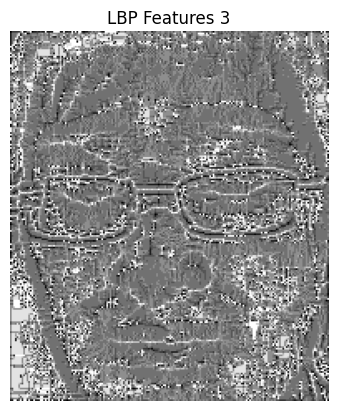

In [17]:
# Display a few FFT and LBP features
for i in range(3):
    display_image(fft_features[i], title=f"FFT Features {i+1}")
    display_image(lbp_features[i], title=f"LBP Features {i+1}")

## Depth Information (Simplified Approach)

In [18]:
def extract_depth_features(lbp_feature):
    """
    Simplified depth feature extraction using the variance of LBP features.
    """
    depth_feature = np.var(lbp_feature)
    return depth_feature

In [19]:
# Extract simplified depth features
depth_features = []

for lbp_feature in lbp_features:
    depth_feature = extract_depth_features(lbp_feature)
    depth_features.append(depth_feature)

In [20]:
# Display a few depth features
print("Depth Features (variance of LBP features):")
for i in range(3):
    print(f"Depth Feature {i+1}: {depth_features[i]}")

Depth Features (variance of LBP features):
Depth Feature 1: 3.2537233979048397
Depth Feature 2: 6.283467827697421
Depth Feature 3: 3.2159721396348417


# Deep Learning Method

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
import os

In [22]:
import pandas as pd

# Directory containing the cropped face images
cropped_faces_dir = '/content/cropped_faces/train_img/color'

# Load the labels (assuming labels.csv contains two columns: 'filename' and 'label')
labels_df = pd.read_csv('/content/labels.csv')

# Load images and labels
images = []
labels = []
for index, row in labels_df.iterrows():
    image_path = os.path.join(cropped_faces_dir, row['filename'])
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    images.append(image)
    labels.append(row['label'])

images = np.array(images)
labels = np.array(labels)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize the images
X_train = X_train / 255.0
X_val = X_val / 255.0


FileNotFoundError: [Errno 2] No such file or directory: '/content/labels.csv'